<a href="https://colab.research.google.com/github/charlottevedrines/StreetcarDelayPredictor/blob/main/Lab3_Gesture_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 3: Gesture Recognition using Convolutional Neural Networks

In this lab you will train a convolutional neural network to make classifications on different hand gestures. By the end of the lab, you should be able to:

1. Load and split data for training, validation and testing
2. Train a Convolutional Neural Network
3. Apply transfer learning to improve your model

Note that for this lab we will not be providing you with any starter code. You should be able to take the code used in previous labs, tutorials and lectures and modify it accordingly to complete the tasks outlined below.

### What to submit

Submit a PDF file containing all your code, outputs, and write-up
from parts 1-5. You can produce a PDF of your Google Colab file by
going to **File > Print** and then save as PDF. The Colab instructions
has more information. Make sure to review the PDF submission to ensure that your answers are easy to read. Make sure that your text is not cut off at the margins.

**Do not submit any other files produced by your code.**

Include a link to your colab file in your submission.

Please use Google Colab to complete this assignment. If you want to use Jupyter Notebook, please complete the assignment and upload your Jupyter Notebook file to Google Colab for submission.

## Colab Link

Include a link to your colab file here

Colab Link: https://drive.google.com/file/d/1rwl8x5wd1tr_KFBgepL4sg9IaAdZKmWh/view?usp=sharing

## Dataset

American Sign Language (ASL) is a complete, complex language that employs signs made by moving the
hands combined with facial expressions and postures of the body. It is the primary language of many
North Americans who are deaf and is one of several communication options used by people who are deaf or
hard-of-hearing. The hand gestures representing English alphabet are shown below. This lab focuses on classifying a subset
of these hand gesture images using convolutional neural networks. Specifically, given an image of a hand
showing one of the letters A-I, we want to detect which letter is being represented.

![alt text](https://www.disabled-world.com/pics/1/asl-alphabet.jpg)

## Part B. Building a CNN [50 pt]

For this lab, we are not going to give you any starter code. You will be writing a convolutional neural network
from scratch. You are welcome to use any code from previous labs, lectures and tutorials. You should also
write your own code.

You may use the PyTorch documentation freely. You might also find online tutorials helpful. However, all
code that you submit must be your own.

Make sure that your code is vectorized, and does not contain obvious inefficiencies (for example, unecessary
for loops, or unnecessary calls to unsqueeze()). Ensure enough comments are included in the code so that
your TA can understand what you are doing. It is your responsibility to show that you understand what you
write.

**This is much more challenging and time-consuming than the previous labs.** Make sure that you
give yourself plenty of time by starting early.

### 1. Data Loading and Splitting [5 pt]

Download the anonymized data provided on Quercus. To allow you to get a heads start on this project we will provide you with sample data from previous years. Split the data into training, validation, and test sets.

Note: Data splitting is not as trivial in this lab. We want our test set to closely resemble the setting in which
our model will be used. In particular, our test set should contain hands that are never seen in training!

Explain how you split the data, either by describing what you did, or by showing the code that you used.
Justify your choice of splitting strategy. How many training, validation, and test images do you have?

For loading the data, you can use plt.imread as in Lab 1, or any other method that you choose. You may find
torchvision.datasets.ImageFolder helpful. (see https://pytorch.org/docs/stable/torchvision/datasets.html?highlight=image%20folder#torchvision.datasets.ImageFolder
)

In [140]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [141]:
!ls "/content/drive/My Drive/APS360/Lab3/data"

A  B  C  D  E  F  G  H	I


In [156]:
# Splitting the dataset into a train, test and validation set with a 80-10-10 split respectively
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Create an ImageFolder instance aka a dataloader
dataset = datasets.ImageFolder(root='/content/drive/My Drive/APS360/Lab3/data', transform=transform)


import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
import torch

batch_size = 64

# Shuffle and split the training set from the rest
np.random.seed(1000)
indices = list(range(len(dataset)))  # Generate indices for the entire dataset
np.random.shuffle(indices)
split_train = int(len(indices) * 0.8)  # 80-20 split
train_indices, test_val_indices = indices[:split_train], indices[split_train:]

# Shuffle and split the rest into testing and validation sets
np.random.shuffle(test_val_indices)
split_test_val = int(len(test_val_indices) * 0.5)  # 50-50 split
test_indices, val_indices = test_val_indices[:split_test_val], test_val_indices[split_test_val:]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_sampler, num_workers=1)
print("len train_loader ", len(train_loader))

val_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=val_sampler, num_workers=1)
print("len val_loader ", len(val_loader))

test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=test_sampler, num_workers=1)
print("len test_loader ", len(test_loader))


# Collecting the small dataset for part 2
split = int(len(train_indices) * 0.05)
train_indices_small = train_indices[:split]

small_sampler = SubsetRandomSampler(train_indices_small)

small_loader = torch.utils.data.DataLoader(dataset, batch_size=64, sampler=small_sampler, num_workers=1)
print("len small_loader ", len(small_loader))

len train_loader  29
len val_loader  4
len test_loader  4
len small_loader  2


In [143]:
print("The length of a dataloader represents the number of batches. Because our batch size is 64, the number of images for our training set is: ",len(train_loader)* batch_size)
print("The length of the validation set is: ", len(val_loader)*batch_size)
print("The length of the test set is: ", len(test_loader)*batch_size)

The length of a dataloader represents the number of batches. Because our batch size is 64, the number of images for our training set is:  1856
The length of the validation set is:  256
The length of the test set is:  256


### 2. Model Building and Sanity Checking [15 pt]

### Part (a) Convolutional Network - 5 pt

Build a convolutional neural network model that takes the (224x224 RGB) image as input, and predicts the gesture
letter. Your model should be a subclass of nn.Module. Explain your choice of neural network architecture: how
many layers did you choose? What types of layers did you use? Were they fully-connected or convolutional?
What about other decisions like pooling layers, activation functions, number of channels / hidden units?

The CNN has two convolutional layers: the first layer has 3 input channels (for RGB images) and 5 output channels using a 5x5 kernel, the second convolutional layer increased its depth to 10 output channels with the same kernel size. There are 2 max pooling layers (2x2 kernel, stride of 2) to reduce spatial dimensions and filter down on dominant features, to improve efficiency.

The chosen activation functions are ReLU as they have been proven to perform well.

The extracted features from the convolutional layers are then flattened and passed through two fully-connected layers, with a reduction in dimensionality to 32 units in the first dense layer before mapping to 9 output classes.

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import torch.optim as optim

In [ ]:
class CNN_Classifier(nn.Module):
    def __init__(self):
        super(CNN_Classifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 5, 5) #in_channels, out_chanels, kernel_size
        self.pool = nn.MaxPool2d(2, 2) #kernel_size, stride
        self.conv2 = nn.Conv2d(5, 10, 5) #in_channels, out_chanels, kernel_size
        self.fc1 = nn.Linear(28090, 32)
        self.fc2 = nn.Linear(32, 9)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 28090)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### Part (b) Training Code - 5 pt

Write code that trains your neural network given some training data. Your training code should make it easy
to tweak the usual hyperparameters, like batch size, learning rate, and the model object itself. Make sure
that you are checkpointing your models from time to time (the frequency is up to you). Explain your choice
of loss function and optimizer.

In [157]:
def get_accuracy(model, loader, train=False):
    if train:
        data = loader
    else:
        data = val_loader

    correct = 0
    total = 0
    for imgs, labels in data:
        output = model(imgs)
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [158]:
import time

def train(model, loader, batch_size=64, num_epochs=1, lr=0.01):

    total_batches = len(loader)
    print(f"Starting training for {num_epochs} epochs, {total_batches} batches per epoch.")
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    iters, losses, train_acc, val_acc = [], [], [], []
    start_time = time.time()  # Record the start time
    # training
    n = 0
    best_val_acc = 0
    for epoch in range(num_epochs):
        epoch_start_time = time.time()  # Start time of the current epoch
        for i, (imgs, labels) in enumerate(loader):
            out = model(imgs)
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            train_acc.append(get_accuracy(model, loader, train=True)) # compute training accuracy
            val_acc.append(get_accuracy(model, loader, train=False))  # compute validation accuracy
            current_val_acc = get_accuracy(model, val_loader, train=False)
            n += 1

            # Saving the best model weights for the test set
            if current_val_acc > best_val_acc:
              best_val_acc = current_val_acc
              best_model_path = 'best_model_weights.pth'
              torch.save(model.state_dict(), best_model_path)

            if (i + 1) % 10 == 0:  # Print every 10 batches
                print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_batches}], Loss: {loss.item():.4f}, Time elapsed: {time.time() - start_time:.2f} seconds")

        # Print epoch duration and reset epoch timer
        print(f"Epoch [{epoch+1}/{num_epochs}] completed in {time.time() - epoch_start_time:.2f} seconds")

    total_duration = time.time() - start_time
    total_duration_min = total_duration/60
    print(f"Training completed in {total_duration_min:.2f} minutes.")

    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))



CNN_Classifier(
  (conv1): Conv2d(3, 5, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(5, 10, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=28090, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=9, bias=True)
)
Starting training for 5 epochs, 29 batches per epoch.
Epoch [1/5], Step [10/29], Loss: 2.1823, Time elapsed: 566.88 seconds
Epoch [1/5], Step [20/29], Loss: 2.1292, Time elapsed: 827.62 seconds
Epoch [1/5] completed in 1059.25 seconds
Epoch [2/5], Step [10/29], Loss: 2.0600, Time elapsed: 1299.07 seconds
Epoch [2/5], Step [20/29], Loss: 1.7018, Time elapsed: 1529.34 seconds
Epoch [2/5] completed in 696.02 seconds
Epoch [3/5], Step [10/29], Loss: 1.3919, Time elapsed: 1991.95 seconds
Epoch [3/5], Step [20/29], Loss: 1.2784, Time elapsed: 2231.97 seconds
Epoch [3/5] completed in 706.62 seconds
Epoch [4/5], Step [10/29], Loss: 1.3782, Time elapsed: 26

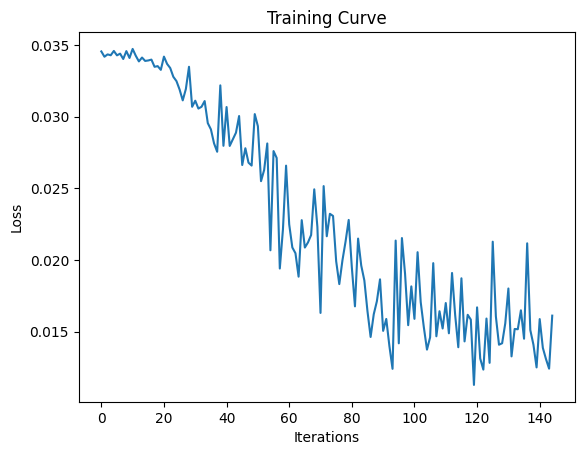

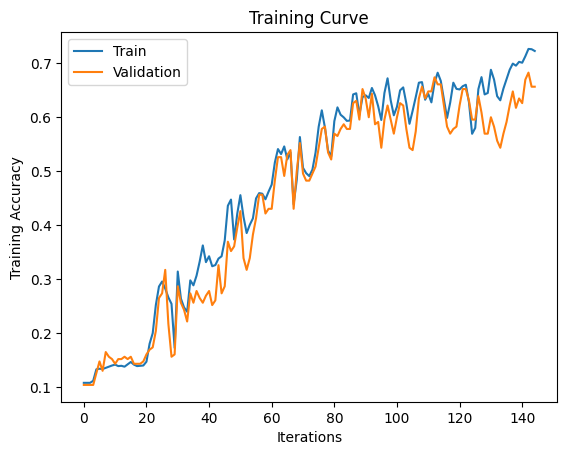

Final Training Accuracy: 0.7226753670473083
Final Validation Accuracy: 0.6565217391304348


In [ ]:
model = CNN_Classifier()
print(model)
train(model, train_loader, num_epochs=5, lr = 0.01)

### Part (c) “Overfit” to a Small Dataset - 5 pt

One way to sanity check our neural network model and training code is to check whether the model is capable
of “overfitting” or “memorizing” a small dataset. A properly constructed CNN with correct training code
should be able to memorize the answers to a small number of images quickly.

Construct a small dataset (e.g. just the images that you have collected). Then show that your model and
training code is capable of memorizing the labels of this small data set.

With a large batch size (e.g. the entire small dataset) and learning rate that is not too high, You should be
able to obtain a 100% training accuracy on that small dataset relatively quickly (within 200 iterations).

CNN_Classifier(
  (conv1): Conv2d(3, 5, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(5, 10, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=28090, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=9, bias=True)
)
Starting training for 60 epochs, 2 batches per epoch.
Epoch [1/60] completed in 12.24 seconds
Epoch [2/60] completed in 12.78 seconds
Epoch [3/60] completed in 12.84 seconds
Epoch [4/60] completed in 11.69 seconds
Epoch [5/60] completed in 12.10 seconds
Epoch [6/60] completed in 12.80 seconds
Epoch [7/60] completed in 11.31 seconds
Epoch [8/60] completed in 11.73 seconds
Epoch [9/60] completed in 12.62 seconds
Epoch [10/60] completed in 12.34 seconds
Epoch [11/60] completed in 12.76 seconds
Epoch [12/60] completed in 12.66 seconds
Epoch [13/60] completed in 12.57 seconds
Epoch [14/60] completed in 12.33 seconds
Epoch [15/60] completed in 11.84 seco

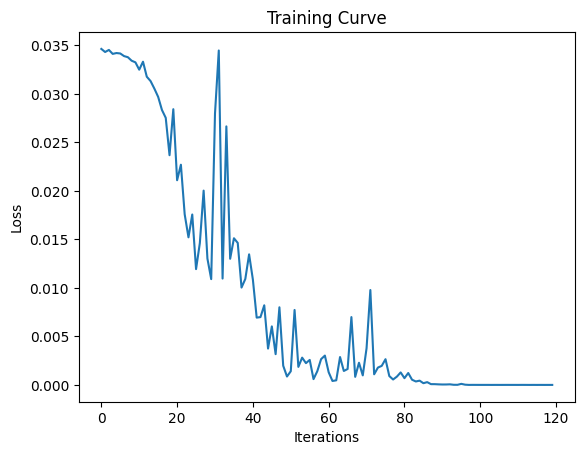

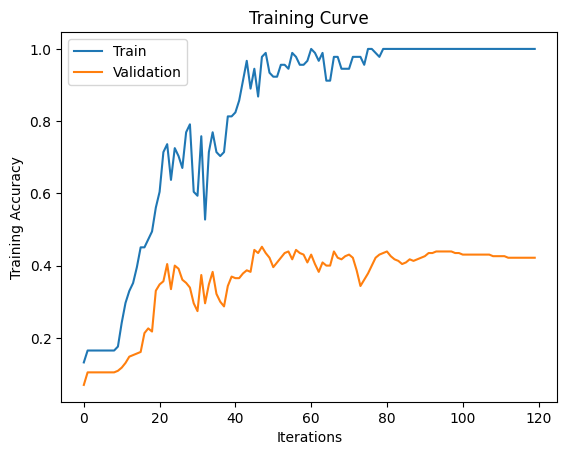

Final Training Accuracy: 1.0
Final Validation Accuracy: 0.4217391304347826


In [ ]:
# Train the model on a smaller set
model = CNN_Classifier()
print(model)
train(model, small_loader, num_epochs=60, lr = 0.01)

### 3. Hyperparameter Search [15 pt]

### Part (a) - 3 pt

List 3 hyperparameters that you think are most worth tuning. Choose at least one hyperparameter related to
the model architecture.

1. The learning rate: the step size in finding the minimum in our gradient
2. The batch size: the number of images passed in the model before calculating the gradient.
3. The number of convolutional layers: determines the depth of network which can help the model learn more complex features.

### Part (b) - 5 pt

Tune the hyperparameters you listed in Part (a), trying as many values as you need to until you feel satisfied
that you are getting a good model. Plot the training curve of at least 4 different hyperparameter settings.

### Increasing the batch size

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataset = None
train_loader = None
val_loader = None
test_loader = None

In [ ]:
# Splitting the dataset into a train, test and validation set with a 80-10-10 split respectively
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

dataset = datasets.ImageFolder(root='/content/drive/My Drive/APS360/Lab3/data', transform=transform)


import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
import torch

batch_size = 150

# Shuffle and split the training set from the rest
np.random.seed(1000)
indices = list(range(len(dataset)))
np.random.shuffle(indices)
split_train = int(len(indices) * 0.8)  # 80-20 split
train_indices, test_val_indices = indices[:split_train], indices[split_train:]

# Shuffle and split the rest into testing and validation sets
np.random.shuffle(test_val_indices)
split_test_val = int(len(test_val_indices) * 0.5)  # 50-50 split
test_indices, val_indices = test_val_indices[:split_test_val], test_val_indices[split_test_val:]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_sampler, num_workers=1)
print("len train_loader ", len(train_loader))

val_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=val_sampler, num_workers=1)
print("len val_loader ", len(val_loader))

test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=test_sampler, num_workers=1)
print("len test_loader ", len(test_loader))


# Collecting the small dataset for part 2
split = int(len(train_indices) * 0.05)
train_indices_small = train_indices[:split]
small_sampler = SubsetRandomSampler(train_indices_small)
small_loader = torch.utils.data.DataLoader(dataset, batch_size=64, sampler=small_sampler, num_workers=1)
print("len small_loader ", len(small_loader))

len train_loader  13
len val_loader  2
len test_loader  2
len small_loader  2


CNN_Classifier(
  (conv1): Conv2d(3, 5, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(5, 10, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=28090, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=9, bias=True)
)
Starting training for 5 epochs, 13 batches per epoch.
Epoch [1/5], Step [10/13], Loss: 2.1469, Time elapsed: 338.18 seconds
Epoch [1/5] completed in 442.53 seconds
Epoch [2/5], Step [10/13], Loss: 1.8589, Time elapsed: 781.92 seconds
Epoch [2/5] completed in 436.89 seconds
Epoch [3/5], Step [10/13], Loss: 1.5396, Time elapsed: 1216.55 seconds
Epoch [3/5] completed in 431.22 seconds
Epoch [4/5], Step [10/13], Loss: 1.3147, Time elapsed: 1643.49 seconds
Epoch [4/5] completed in 428.23 seconds
Epoch [5/5], Step [10/13], Loss: 1.0115, Time elapsed: 2057.84 seconds
Epoch [5/5] completed in 410.42 seconds
Training completed in 35.82 minutes.


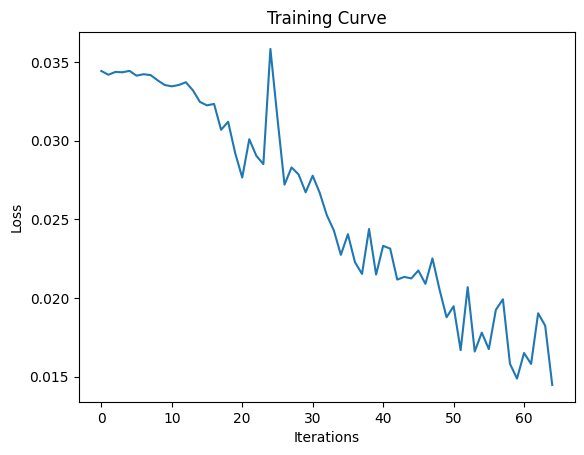

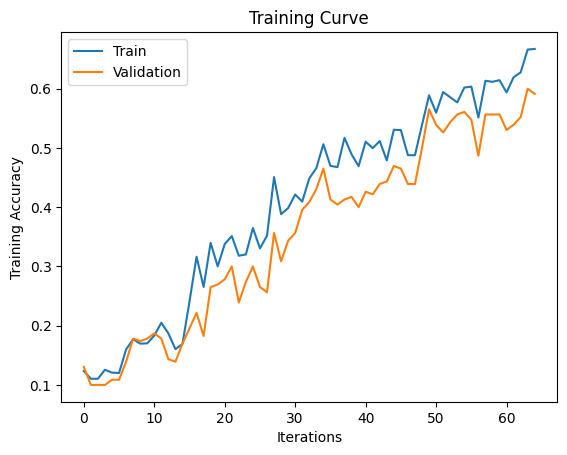

Final Training Accuracy: 0.66721044045677
Final Validation Accuracy: 0.591304347826087


In [ ]:
model = CNN_Classifier()
print(model)
train(model, train_loader, num_epochs=5, lr = 0.01)

### Increasing the learning rate

In [ ]:
# Splitting the dataset into a train, test and validation set with a 80-10-10 split respectively
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Create an ImageFolder instance aka a dataloader
dataset = datasets.ImageFolder(root='/content/drive/My Drive/APS360/Lab3/data', transform=transform)

import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
import torch

batch_size = 64

# Shuffle and split the training set from the rest
np.random.seed(1000)
indices = list(range(len(dataset)))  # Generate indices for the entire dataset
np.random.shuffle(indices)
split_train = int(len(indices) * 0.8)  # 80-20 split
train_indices, test_val_indices = indices[:split_train], indices[split_train:]

# Shuffle and split the rest into testing and validation sets
np.random.shuffle(test_val_indices)
split_test_val = int(len(test_val_indices) * 0.5)  # 50-50 split
test_indices, val_indices = test_val_indices[:split_test_val], test_val_indices[split_test_val:]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_sampler, num_workers=1)
print("len train_loader ", len(train_loader))

val_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=val_sampler, num_workers=1)
print("len val_loader ", len(val_loader))

test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=test_sampler, num_workers=1)
print("len test_loader ", len(test_loader))


# Collecting the small dataset for part 2
split = int(len(train_indices) * 0.05)
train_indices_small = train_indices[:split]
small_sampler = SubsetRandomSampler(train_indices_small)
small_loader = torch.utils.data.DataLoader(dataset, batch_size=64, sampler=small_sampler, num_workers=1)
print("len small_loader ", len(small_loader))

len train_loader  29
len val_loader  4
len test_loader  4
len small_loader  2


In [ ]:

class CNN_Classifier(nn.Module):
    def __init__(self):
        super(CNN_Classifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 5, 5) #in_channels, out_chanels, kernel_size
        self.pool = nn.MaxPool2d(2, 2) #kernel_size, stride
        self.conv2 = nn.Conv2d(5, 10, 5) #in_channels, out_chanels, kernel_size
        self.fc1 = nn.Linear(28090, 32)
        self.fc2 = nn.Linear(32, 9)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 28090)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

CNN_Classifier(
  (conv1): Conv2d(3, 5, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(5, 10, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=28090, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=9, bias=True)
)
Starting training for 5 epochs, 29 batches per epoch.
Epoch [1/5], Step [10/29], Loss: 2.1732, Time elapsed: 230.94 seconds
Epoch [1/5], Step [20/29], Loss: 2.2096, Time elapsed: 478.93 seconds
Epoch [1/5] completed in 689.76 seconds
Epoch [2/5], Step [10/29], Loss: 2.2020, Time elapsed: 926.59 seconds
Epoch [2/5], Step [20/29], Loss: 2.1841, Time elapsed: 1160.39 seconds
Epoch [2/5] completed in 675.03 seconds
Epoch [3/5], Step [10/29], Loss: 2.1850, Time elapsed: 1580.55 seconds
Epoch [3/5], Step [20/29], Loss: 2.1991, Time elapsed: 1799.26 seconds
Epoch [3/5] completed in 634.93 seconds
Epoch [4/5], Step [10/29], Loss: 2.1920, Time elapsed: 2227

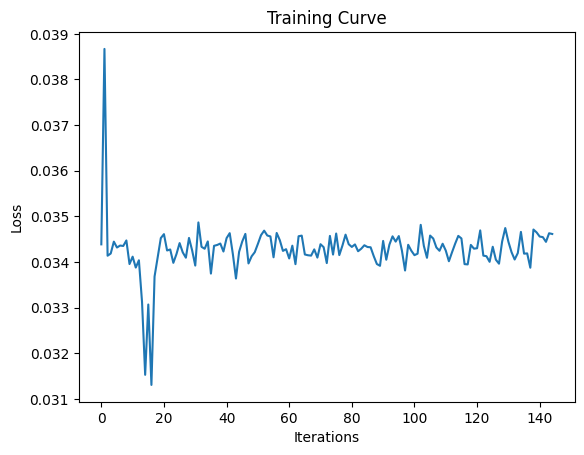

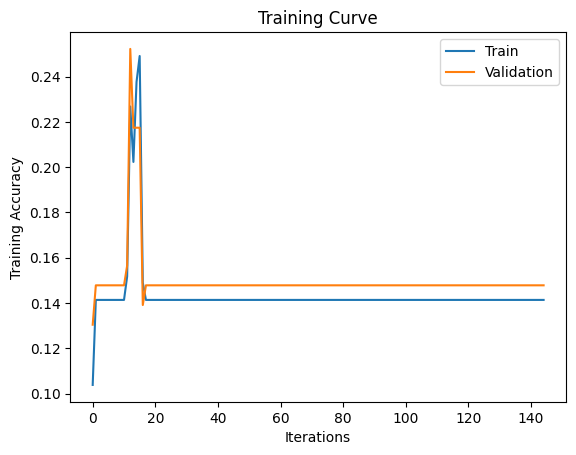

Final Training Accuracy: 0.14138118542686243
Final Validation Accuracy: 0.14782608695652175


In [ ]:
model = CNN_Classifier()
print(model)
train(model, train_loader, num_epochs=5, lr = 0.1)

### Adding a convolutional layer

In [8]:
# Splitting the dataset into a train, test and validation set with a 80-10-10 split respectively
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Create an ImageFolder instance aka a dataloader
dataset = datasets.ImageFolder(root='/content/drive/My Drive/APS360/Lab3/data', transform=transform)


import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
import torch

batch_size = 64

# Shuffle and split the training set from the rest
np.random.seed(1000)
indices = list(range(len(dataset)))  # Generate indices for the entire dataset
np.random.shuffle(indices)
split_train = int(len(indices) * 0.8)  # 80-20 split
train_indices, test_val_indices = indices[:split_train], indices[split_train:]

# Shuffle and split the rest into testing and validation sets
np.random.shuffle(test_val_indices)
split_test_val = int(len(test_val_indices) * 0.5)  # 50-50 split
test_indices, val_indices = test_val_indices[:split_test_val], test_val_indices[split_test_val:]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_sampler, num_workers=1)
print("len train_loader ", len(train_loader))

val_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=val_sampler, num_workers=1)
print("len val_loader ", len(val_loader))

test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=test_sampler, num_workers=1)
print("len test_loader ", len(test_loader))


# Collecting the small dataset for part 2
split = int(len(train_indices) * 0.05)
train_indices_small = train_indices[:split]
small_sampler = SubsetRandomSampler(train_indices_small)
small_loader = torch.utils.data.DataLoader(dataset, batch_size=64, sampler=small_sampler, num_workers=1)
print("len small_loader ", len(small_loader))

len train_loader  29
len val_loader  4
len test_loader  4
len small_loader  2


In [162]:
import torch.nn as nn
import torch.nn.functional as F

class CNN_Classifier(nn.Module):
    def __init__(self):
        super(CNN_Classifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 5, 5)  # in_channels, out_channels, kernel_size
        self.pool = nn.MaxPool2d(2, 2)  # kernel_size, stride
        self.conv2 = nn.Conv2d(5, 10, 5)  # in_channels, out_channels, kernel_size
        self.conv3 = nn.Conv2d(10, 20, 5)  # New convolutional layer
        self.fc1 = nn.Linear(11520, 32)
        self.fc2 = nn.Linear(32, 9)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 11520)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


CNN_Classifier(
  (conv1): Conv2d(3, 5, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(5, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=11520, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=9, bias=True)
)
Starting training for 5 epochs, 29 batches per epoch.
Epoch [1/5], Step [10/29], Loss: 2.1977, Time elapsed: 305.65 seconds


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x78bb2d1a9000>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process


Epoch [1/5], Step [20/29], Loss: 2.1929, Time elapsed: 594.83 seconds
Epoch [1/5] completed in 858.27 seconds
Epoch [2/5], Step [10/29], Loss: 2.1931, Time elapsed: 1151.21 seconds
Epoch [2/5], Step [20/29], Loss: 2.1356, Time elapsed: 1442.05 seconds
Epoch [2/5] completed in 842.62 seconds
Epoch [3/5], Step [10/29], Loss: 2.2394, Time elapsed: 1989.81 seconds
Epoch [3/5], Step [20/29], Loss: 1.6565, Time elapsed: 2278.53 seconds
Epoch [3/5] completed in 836.12 seconds
Epoch [4/5], Step [10/29], Loss: 1.4563, Time elapsed: 2820.41 seconds
Epoch [4/5], Step [20/29], Loss: 1.3207, Time elapsed: 3103.50 seconds
Epoch [4/5] completed in 822.87 seconds
Epoch [5/5], Step [10/29], Loss: 0.9902, Time elapsed: 3643.99 seconds
Epoch [5/5], Step [20/29], Loss: 1.0544, Time elapsed: 3936.08 seconds
Epoch [5/5] completed in 833.07 seconds
Training completed in 69.88 minutes.


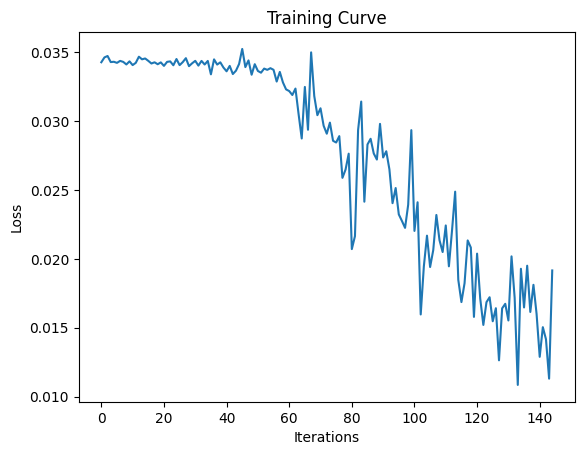

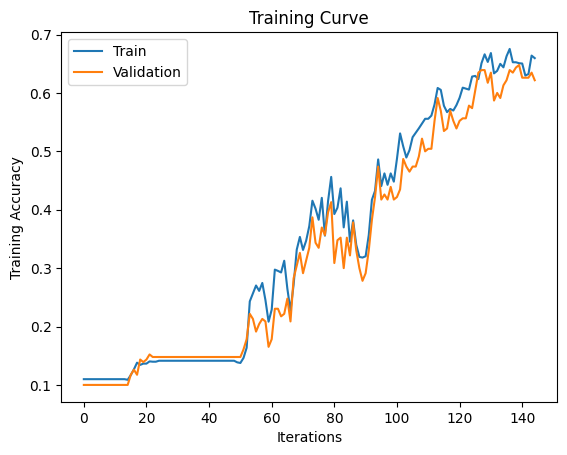

Final Training Accuracy: 0.6595976073953236
Final Validation Accuracy: 0.6217391304347826


In [ ]:
model = CNN_Classifier()
print(model)
train(model, train_loader, num_epochs=5, lr = 0.01)

### CL and learning rate

CNN_Classifier(
  (conv1): Conv2d(3, 5, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(5, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=11520, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=9, bias=True)
)
Starting training for 5 epochs, 29 batches per epoch.
Epoch [1/5], Step [10/29], Loss: 2.2064, Time elapsed: 351.56 seconds
Epoch [1/5], Step [20/29], Loss: 2.1721, Time elapsed: 683.05 seconds
Epoch [1/5] completed in 976.54 seconds
Epoch [2/5], Step [10/29], Loss: 2.1933, Time elapsed: 1302.27 seconds
Epoch [2/5], Step [20/29], Loss: 2.1737, Time elapsed: 1627.44 seconds
Epoch [2/5] completed in 942.27 seconds
Epoch [3/5], Step [10/29], Loss: 2.0931, Time elapsed: 2240.93 seconds
Epoch [3/5], Step [20/29], Loss: 1.7558, Time elapsed: 2558.36 seconds
Epoch [3/5] completed in 924.84 secon

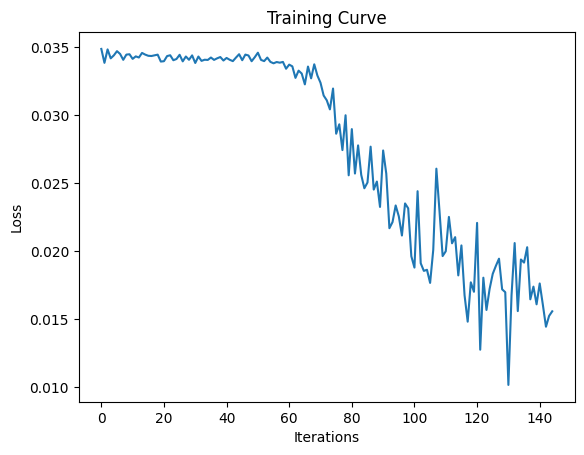

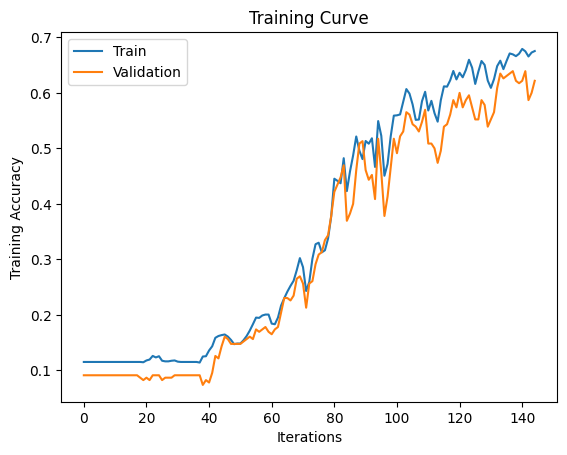

Final Training Accuracy: 0.6753670473083198
Final Validation Accuracy: 0.6217391304347826


In [161]:
model = CNN_Classifier()
print(model)
train(model, train_loader, num_epochs=5, lr = 0.005)

In [163]:
model_best = CNN_Classifier()

# Load the best model weights saved during training
best_model_path = 'best_model_weights.pth'
model_best.load_state_dict(torch.load(best_model_path))

# Set the model to evaluation mode
model_best.eval()

test_accuracy = get_accuracy(model_best, test_loader, train=False)
print("Test Accuracy with Best Model: ", test_accuracy)

Test Accuracy with Best Model: 0.6391304347826087


### Part (c) - 3 pt
Choose the best model out of all the ones that you have trained. Justify your choice.

The best model had 3 convolutional layers, was trained on 5 epochs, a batch size of 64 and a learning rate of 0.005.

This choice was based on the model that displayed the best accuracy results on the validation set as picked a model from the best training results could lead to choosing an overfit model.

### Part (d) - 4 pt
Report the test accuracy of your best model. You should only do this step once and prior to this step you should have only used the training and validation data.

In [ ]:
model_best = CNN_Classifier()

# Load the best model weights saved during training
best_model_path = 'best_model_weights.pth'
model_best.load_state_dict(torch.load(best_model_path))

# Set the model to evaluation mode
model_best.eval()

test_accuracy = get_accuracy(model_best, test_loader, train=False)
print(f"Test Accuracy with Best Model: {test_accuracy}")


### 4. Transfer Learning [15 pt]
For many image classification tasks, it is generally not a good idea to train a very large deep neural network
model from scratch due to the enormous compute requirements and lack of sufficient amounts of training
data.

One of the better options is to try using an existing model that performs a similar task to the one you need
to solve. This method of utilizing a pre-trained network for other similar tasks is broadly termed **Transfer
Learning**. In this assignment, we will use Transfer Learning to extract features from the hand gesture
images. Then, train a smaller network to use these features as input and classify the hand gestures.

As you have learned from the CNN lecture, convolution layers extract various features from the images which
get utilized by the fully connected layers for correct classification. AlexNet architecture played a pivotal
role in establishing Deep Neural Nets as a go-to tool for image classification problems and we will use an
ImageNet pre-trained AlexNet model to extract features in this assignment.

### Part (a) - 5 pt
Here is the code to load the AlexNet network, with pretrained weights. When you first run the code, PyTorch
will download the pretrained weights from the internet.

In [131]:
import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


The alexnet model is split up into two components: *alexnet.features* and *alexnet.classifier*. The
first neural network component, *alexnet.features*, is used to compute convolutional features, which are
taken as input in *alexnet.classifier*.

The neural network alexnet.features expects an image tensor of shape Nx3x224x224 as input and it will
output a tensor of shape Nx256x6x6 . (N = batch size).

Compute the AlexNet features for each of your training, validation, and test data. Here is an example code
snippet showing how you can compute the AlexNet features for some images (your actual code might be
different):

In [144]:
training_features = []
training_labels =[]

with torch.no_grad():
    for inputs, target in train_loader:
        output = alexnet.features(inputs)

        training_features.append(output)
        training_labels.append(target)

training_features = torch.cat(training_features)
training_labels = torch.cat(training_labels)

inputs  torch.Size([64, 3, 224, 224])
inputs  torch.Size([64, 3, 224, 224])
inputs  torch.Size([64, 3, 224, 224])
inputs  torch.Size([64, 3, 224, 224])
inputs  torch.Size([64, 3, 224, 224])
inputs  torch.Size([64, 3, 224, 224])
inputs  torch.Size([64, 3, 224, 224])
inputs  torch.Size([64, 3, 224, 224])
inputs  torch.Size([64, 3, 224, 224])
inputs  torch.Size([64, 3, 224, 224])
inputs  torch.Size([64, 3, 224, 224])
inputs  torch.Size([64, 3, 224, 224])
inputs  torch.Size([64, 3, 224, 224])
inputs  torch.Size([64, 3, 224, 224])
inputs  torch.Size([64, 3, 224, 224])
inputs  torch.Size([64, 3, 224, 224])
inputs  torch.Size([64, 3, 224, 224])
inputs  torch.Size([64, 3, 224, 224])
inputs  torch.Size([64, 3, 224, 224])
inputs  torch.Size([64, 3, 224, 224])
inputs  torch.Size([64, 3, 224, 224])
inputs  torch.Size([64, 3, 224, 224])
inputs  torch.Size([64, 3, 224, 224])
inputs  torch.Size([64, 3, 224, 224])
inputs  torch.Size([64, 3, 224, 224])
inputs  torch.Size([64, 3, 224, 224])
inputs  torc

In [145]:
validation_features = []
validation_labels =[]

with torch.no_grad():
    for inputs, target in val_loader:
        output = alexnet.features(inputs)
        validation_features.append(output)
        validation_labels.append(target)

validation_features = torch.cat(validation_features)
validation_labels = torch.cat(validation_labels)

In [146]:
test_features = []
test_labels =[]

with torch.no_grad():
    for inputs, target in test_loader:
        output = alexnet.features(inputs)
        test_features.append(output)
        test_labels.append(target)

test_features = torch.cat(test_features)
test_labels = torch.cat(test_labels)

**Save the computed features**. You will be using these features as input to your neural network in Part
(b), and you do not want to re-compute the features every time. Instead, run *alexnet.features* once for
each image, and save the result.

### Part (b) - 3 pt
Build a convolutional neural network model that takes as input these AlexNet features, and makes a
prediction. Your model should be a subclass of nn.Module.

Explain your choice of neural network architecture: how many layers did you choose? What types of layers
did you use: fully-connected or convolutional? What about other decisions like pooling layers, activation
functions, number of channels / hidden units in each layer?

Here is an example of how your model may be called:

I chose a similar model to the one previously used because I got good results. However, I chose 2 convolutional layers eventhough 3 produced better results previously in the interest of saving compute given that the features have already been extracted from the pretrained neural network and therefore a deep deep neural network was not need to extract deep features.

The first convolutional layer takes the number of feature maps (256) from alexnet's features tensor as the number of input channels. The number of output chanels is then reduced to 50 in the first convolutional layer and 10 in the second.

There are 2 fully connected layers and a max pooling layers.

In [147]:
class CNN_Classifier2(nn.Module):
    def __init__(self):
        super(CNN_Classifier2, self).__init__()
        self.conv1 = nn.Conv2d(256, 50, 3) #in_channels, out_chanels, kernel_size
        self.pool = nn.MaxPool2d(2, 2) #kernel_size, stride
        #self.conv2 = nn.Conv2d(50, 10, 3) #in_channels, out_chanels, kernel_size
        self.fc1 = nn.Linear(50 * 2 * 2, 32)
        self.fc2 = nn.Linear(32, 9)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
       # x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 50 * 2 * 2)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

### Part (c) - 5 pt
Train your new network, including any hyperparameter tuning. Plot and submit the training curve of your
best model only.

Note: Depending on how you are caching (saving) your AlexNet features, PyTorch might still be tracking
updates to the **AlexNet weights**, which we are not tuning. One workaround is to convert your AlexNet
feature tensor into a numpy array, and then back into a PyTorch tensor.

In [148]:
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(training_features, training_labels)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

vald_dataset = TensorDataset(validation_features, validation_labels)
vald_loader = DataLoader(vald_dataset, batch_size=64, shuffle=True)

In [149]:
inputs, labels = next(iter(train_loader))

print("Batch inputs shape:", inputs.size())
print("Batch labels shape:", labels.size())

Batch inputs shape: torch.Size([64, 256, 6, 6])
Batch labels shape: torch.Size([64])


In [150]:
def get_accuracy2(model, loader, train=False):
    if train:
        data = loader
    else:
        data = vald_loader

    correct = 0
    total = 0
    for imgs, labels in data:

        output = model(imgs)

        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [151]:
num_epochs = 5
loader = train_loader
model2 = CNN_Classifier2()

total_batches = len(loader)
print(f"Starting training for {num_epochs} epochs, {total_batches} batches per epoch.")

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model2.parameters(), lr=0.01, momentum=0.9)

iters, losses, train_acc, val_acc = [], [], [], []

start_time = time.time()  # Record the start time

# training
n = 0 # the number of iterations
best_val_acc = 0

for epoch in range(num_epochs):
    epoch_start_time = time.time()  # Start time of the current epoch
    for i, (imgs, labels) in enumerate(loader):

        out = model2(imgs)             # forward pass

        loss = criterion(out, labels) # compute the total loss
        loss.backward()               # backward pass (compute parameter updates)
        optimizer.step()              # make the updates for each parameter
        optimizer.zero_grad()         # a clean up step for PyTorch

        # save the current training information
        iters.append(n)
        losses.append(float(loss)/batch_size)             # compute *average* loss
        train_acc.append(get_accuracy2(model2, loader, train=True)) # compute training accuracy
        val_acc.append(get_accuracy2(model2, loader, train=False))  # compute validation accuracy
        current_val_acc = get_accuracy2(model2, val_loader, train=False)
        n += 1

        if current_val_acc > best_val_acc:
              best_val_acc = current_val_acc
              best_model_path = 'best_model_weights.pth'
              torch.save(model.state_dict(), best_model_path)
              print("New best model saved to ",best_model_path, " with validation accuracy: ", best_val_acc)

        if (i + 1) % 10 == 0:  # Print every 10 batches
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_batches}], Loss: {loss.item():.4f}, Time elapsed: {time.time() - start_time:.2f} seconds")

    # Print epoch duration and reset epoch timer
    print(f"Epoch [{epoch+1}/{num_epochs}] completed in {time.time() - epoch_start_time:.2f} seconds")

total_duration = time.time() - start_time
total_duration_min = total_duration/60
print(f"Training completed in {total_duration_min:.2f} minutes.")


Starting training for 5 epochs, 29 batches per epoch.
New best model saved to best_model_weights.pth with validation accuracy: 0.12173913043478261
New best model saved to best_model_weights.pth with validation accuracy: 0.12608695652173912
New best model saved to best_model_weights.pth with validation accuracy: 0.17391304347826086
New best model saved to best_model_weights.pth with validation accuracy: 0.21304347826086956
New best model saved to best_model_weights.pth with validation accuracy: 0.2217391304347826
New best model saved to best_model_weights.pth with validation accuracy: 0.24347826086956523
New best model saved to best_model_weights.pth with validation accuracy: 0.2826086956521739
New best model saved to best_model_weights.pth with validation accuracy: 0.34347826086956523
New best model saved to best_model_weights.pth with validation accuracy: 0.3826086956521739
Epoch [1/5], Step [10/29], Loss: 2.0541, Time elapsed: 4.70 seconds
New best model saved to best_model_weights.p

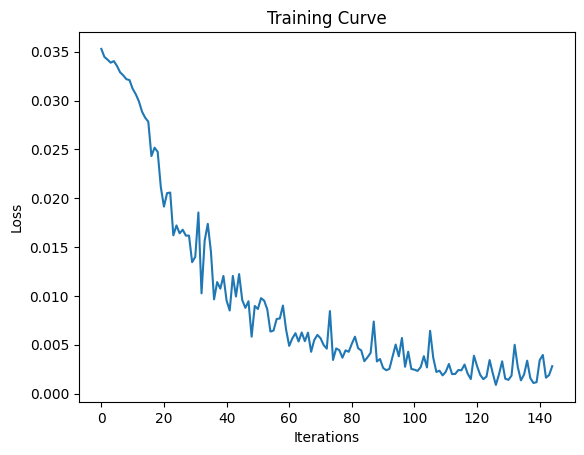

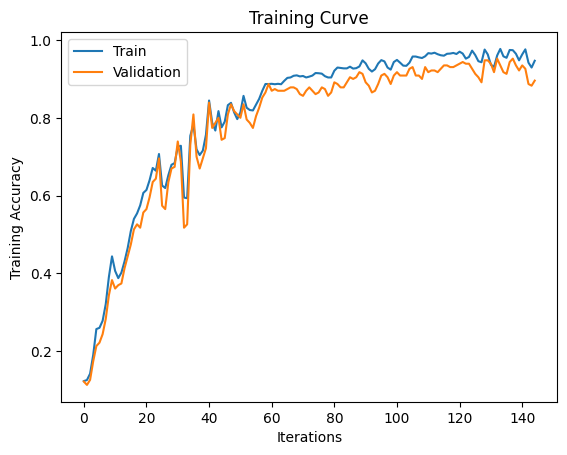

Final Training Accuracy: 0.9467101685698749
Final Validation Accuracy: 0.8956521739130435


In [152]:
# plotting
plt.title("Training Curve")
plt.plot(iters, losses, label="Train")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.show()

plt.title("Training Curve")
plt.plot(iters, train_acc, label="Train")
plt.plot(iters, val_acc, label="Validation")
plt.xlabel("Iterations")
plt.ylabel("Training Accuracy")
plt.legend(loc='best')
plt.show()

print("Final Training Accuracy: {}".format(train_acc[-1]))
print("Final Validation Accuracy: {}".format(val_acc[-1]))

### Part (d) - 2 pt
Report the test accuracy of your best model. How does the test accuracy compare to Part 3(d) without transfer learning?

In [154]:
model_best = CNN_Classifier2()

best_model_path = 'best_model_weights.pth'
model_best.load_state_dict(torch.load(best_model_path))

model_best.eval()

test_accuracy = get_accuracy2(model_best, test_loader, train=False)
print(f"Test Accuracy with Best Model: {test_accuracy}")


Test Accuracy with Best Model: 0.7521739130434782


The test accuracy of Part 3 (d) from training a CNN from scratch is 0.639 whereas the test accuracy of the CNN with transfer learning is 0.752, revealing the improvement in feature engineering performed by alexnet rather than my CNN. This makes sense because my model isn't as complex, deep or trained on nearly as much data as alexnet was. By finetuning the model with a convolutional layer on our gesture recognition data we where able to obtain much higher results than training a CNN from scratch.